12/06/2021

## Load libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

from sklearn.neural_network import MLPClassifier

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import lightgbm as lgb

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load and set data paths

In [ ]:
Cremad_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/emotion_path.csv')
Ravdess_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/ravdess/ravdess_path.csv')

DF = pd.concat([Cremad_df, Ravdess_df], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


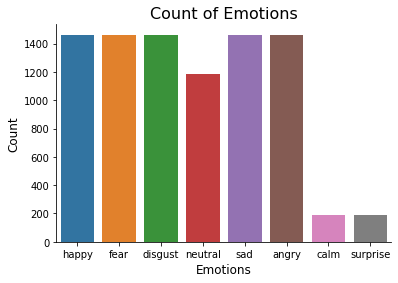

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(DF.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
DF = DF.sample(frac=1).reset_index(drop=True)

## Feature Extraction

In [ ]:
observed_emotions=sorted(['fear', 'happy', 'sad', 'angry'])

In [ ]:
observed_emotions

['angry', 'fear', 'happy', 'sad']

In [ ]:
num_mfcc=13

In [ ]:
def extract_feature(path, mfcc, chroma, mel, tempo):
  data, sample_rate = librosa.load(path, res_type='kaiser_fast')
  if chroma:
    stft = np.abs(librosa.stft(data))

  result=np.array([])
  if mfcc:
    mfccs=np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=num_mfcc).T, axis=0)
    result=np.hstack((result, mfccs))
  if chroma:
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result=np.hstack((result, chroma))
  if mel:
    mel=np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result=np.hstack((result, mel))
  if tempo:
    tempo=np.mean(librosa.feature.tempogram(y=data, sr=sample_rate).T, axis=0)
    result=np.hstack((result, tempo))

  return result

In [ ]:
X, Y = [], []
for path, emotion in zip(DF.Path, DF.Emotions):
  if emotion not in observed_emotions:
    continue
  feature = extract_feature(path, mfcc=False, chroma=False, mel=False, tempo=True)
  X.append(feature)
  Y.append(emotion)

In [ ]:
len(X), len(Y)

(5852, 5852)

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/tempogram_features.csv', index=0)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,labels
0,1.0,0.769231,0.579428,0.598579,0.610200,0.563047,0.515608,0.507909,0.572793,0.655236,0.622888,0.549489,0.550062,0.590368,0.555430,0.470323,0.485661,0.569776,0.567760,0.499673,0.464856,0.495660,0.512830,0.487266,0.408322,0.372152,0.406884,0.473904,0.449675,0.398917,0.475366,0.476830,0.372566,0.327663,0.333626,0.333851,0.316907,0.318697,0.324892,0.363698,...,-5.203993e-17,9.778097e-17,2.825285e-17,6.137894e-17,-8.928696e-18,2.679011e-17,1.001128e-17,2.621800e-17,2.998780e-18,2.688461e-17,1.174837e-17,5.192114e-17,3.291940e-17,7.584072e-17,-4.273089e-17,9.701905e-17,-5.998780e-17,6.461709e-17,-3.559778e-17,2.016138e-17,-1.244597e-17,4.602338e-17,4.423443e-17,-5.544317e-17,7.184415e-17,-5.394965e-17,3.752298e-17,-1.976460e-17,2.863178e-17,-5.243326e-17,9.241662e-17,-4.392101e-17,2.912308e-17,3.294020e-17,-4.342202e-18,5.254957e-17,3.953662e-18,3.167729e-17,2.856812e-17,fear
1,1.0,0.695547,0.332028,0.306594,0.379555,0.420388,0.497067,0.519367,0.418261,0.338050,0.358082,0.367219,0.392495,0.434503,0.405368,0.343195,0.340941,0.339699,0.301201,0.305548,0.383323,0.419703,0.361489,0.292318,0.285669,0.286081,0.255162,0.235035,0.272215,0.311388,0.318390,0.321596,0.278837,0.241124,0.300918,0.342067,0.282738,0.200147,0.167270,0.183333,...,-3.408968e-17,8.118966e-17,1.273357e-17,4.193097e-17,-1.032833e-17,1.576548e-17,1.714063e-17,2.461577e-17,1.004234e-17,1.814530e-17,-1.134592e-18,4.380896e-17,1.743362e-17,5.943747e-17,-9.865765e-18,5.428393e-17,-4.808446e-17,5.498448e-17,-3.749510e-17,9.356396e-18,-4.187359e-19,2.841185e-17,2.943990e-17,-3.562742e-17,3.798366e-17,-4.541525e-17,3.310578e-17,-1.035669e-17,2.160153e-17,-4.189272e-17,7.289959e-17,-2.806159e-17,2.070778e-17,1.507211e-17,-1.406836e-17,3.429549e-17,-8.495918e-19,1.543971e-17,2.062285e-17,happy
2,1.0,0.844096,0.689703,0.701894,0.767203,0.784367,0.738792,0.716749,0.767397,0.820663,0.787633,0.730167,0.750580,0.734523,0.697867,0.686402,0.703679,0.738653,0.747592,0.714522,0.679573,0.705783,0.725399,0.680776,0.645872,0.654314,0.685240,0.676234,0.642539,0.645425,0.664042,0.683378,0.655210,0.620484,0.612401,0.620964,0.630807,0.622964,0.598345,0.591179,...,-8.054862e-17,1.260457e-16,5.524202e-17,5.665564e-17,-3.104336e-17,4.178297e-17,5.673578e-18,1.865496e-17,-1.422112e-17,6.257307e-17,-6.597158e-18,5.457054e-17,5.250044e-17,1.101195e-16,-5.536950e-17,1.353031e-16,-9.102598e-17,8.643705e-17,-4.333704e-17,3.935689e-17,-2.162274e-17,6.455841e-17,8.561485e-17,-7.488670e-17,9.397896e-17,-7.382414e-17,4.235994e-17,-1.593611e-17,3.327921e-17,-8.036677e-17,1.433896e-16,-5.601084e-17,4.651476e-17,4.032456e-17,-1.854609e-17,7.271327e-17,6.873111e-18,3.847740e-17,4.654216e-17,sad
3,1.0,0.827512,0.672599,0.644182,0.667258,0.725982,0.744855,0.684783,0.672446,0.663685,0.636051,0.656816,0.650617,0.615007,0.589097,0.591506,0.639062,0.659356,0.627046,0.610272,0.614317,0.582396,0.557616,0.543259,0.573273,0.628928,0.610628,0.558975,0.539000,0.535692,0.523777,0.531030,0.519776,0.519390,0.485065,0.460350,0.496221,0.510606,0.472578,0.454424,...,-6.183375e-17,1.220346e-16,2.960403e-17,4.676236e-17,-3.228414e-17,4.050781e-17,-8.339661e-18,2.026532e-17,-1.300220e-17,5.342780e-17,-5.319320e-19,6.164073e-17,4.630210e-17,9.171414e-17,-4.130859e-17,1.114639e-16,-8.116322e-17,6.124486e-17,-3.352847e-17,2.739108e-17,-2.022591e-17,4.996208e-17,6.898632e-17,-7.607498e-17,8.512213e-17,-6.203264e-17,3.204653e-17,-1.140268e-17,1.490369e-17,-6.480762e-17,1.078588e-16,-4.872242e-17,4.153884e-17,3.392867e-17,-2.020491e-17,5.658817e-17,-4.011966e-19,1.530921e-17,3.320298e-17,sad
4,1.0,0.803077,0.580889,0.535604,0.570197,0.570067,0.556989,0.588369,0.599164,0.571785,0.551396,0.556614,0.615203,0.638041,0.596347,0.564848,0.551601,0.531970,0.507401,0.50357

## Data Preparation

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/tempogram_features.csv')
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,labels
0,1.0,0.769231,0.579428,0.598579,0.610200,0.563047,0.515608,0.507909,0.572793,0.655236,0.622888,0.549489,0.550062,0.590368,0.555430,0.470323,0.485661,0.569776,0.567760,0.499673,0.464856,0.495660,0.512830,0.487266,0.408322,0.372152,0.406884,0.473904,0.449675,0.398917,0.475366,0.476830,0.372566,0.327663,0.333626,0.333851,0.316907,0.318697,0.324892,0.363698,...,-5.203993e-17,9.778097e-17,2.825285e-17,6.137894e-17,-8.928696e-18,2.679011e-17,1.001128e-17,2.621800e-17,2.998780e-18,2.688461e-17,1.174837e-17,5.192114e-17,3.291940e-17,7.584072e-17,-4.273089e-17,9.701905e-17,-5.998780e-17,6.461709e-17,-3.559778e-17,2.016138e-17,-1.244597e-17,4.602338e-17,4.423443e-17,-5.544317e-17,7.184415e-17,-5.394965e-17,3.752298e-17,-1.976460e-17,2.863178e-17,-5.243326e-17,9.241662e-17,-4.392101e-17,2.912308e-17,3.294020e-17,-4.342202e-18,5.254957e-17,3.953662e-18,3.167729e-17,2.856812e-17,fear
1,1.0,0.695547,0.332028,0.306594,0.379555,0.420388,0.497067,0.519367,0.418261,0.338050,0.358082,0.367219,0.392495,0.434503,0.405368,0.343195,0.340941,0.339699,0.301201,0.305548,0.383323,0.419703,0.361489,0.292318,0.285669,0.286081,0.255162,0.235035,0.272215,0.311388,0.318390,0.321596,0.278837,0.241124,0.300918,0.342067,0.282738,0.200147,0.167270,0.183333,...,-3.408968e-17,8.118966e-17,1.273357e-17,4.193097e-17,-1.032833e-17,1.576548e-17,1.714063e-17,2.461577e-17,1.004234e-17,1.814530e-17,-1.134592e-18,4.380896e-17,1.743362e-17,5.943747e-17,-9.865765e-18,5.428393e-17,-4.808446e-17,5.498448e-17,-3.749510e-17,9.356396e-18,-4.187359e-19,2.841185e-17,2.943990e-17,-3.562742e-17,3.798366e-17,-4.541525e-17,3.310578e-17,-1.035669e-17,2.160153e-17,-4.189272e-17,7.289959e-17,-2.806159e-17,2.070778e-17,1.507211e-17,-1.406836e-17,3.429549e-17,-8.495918e-19,1.543971e-17,2.062285e-17,happy
2,1.0,0.844096,0.689703,0.701894,0.767203,0.784367,0.738792,0.716749,0.767397,0.820663,0.787633,0.730167,0.750580,0.734523,0.697867,0.686402,0.703679,0.738653,0.747592,0.714522,0.679573,0.705783,0.725399,0.680776,0.645872,0.654314,0.685240,0.676234,0.642539,0.645425,0.664042,0.683378,0.655210,0.620484,0.612401,0.620964,0.630807,0.622964,0.598345,0.591179,...,-8.054862e-17,1.260457e-16,5.524202e-17,5.665564e-17,-3.104336e-17,4.178297e-17,5.673578e-18,1.865496e-17,-1.422112e-17,6.257307e-17,-6.597158e-18,5.457054e-17,5.250044e-17,1.101195e-16,-5.536950e-17,1.353031e-16,-9.102598e-17,8.643705e-17,-4.333704e-17,3.935689e-17,-2.162274e-17,6.455841e-17,8.561485e-17,-7.488670e-17,9.397896e-17,-7.382414e-17,4.235994e-17,-1.593611e-17,3.327921e-17,-8.036677e-17,1.433896e-16,-5.601084e-17,4.651476e-17,4.032456e-17,-1.854609e-17,7.271327e-17,6.873111e-18,3.847740e-17,4.654216e-17,sad
3,1.0,0.827512,0.672599,0.644182,0.667258,0.725982,0.744855,0.684783,0.672446,0.663685,0.636051,0.656816,0.650617,0.615007,0.589097,0.591506,0.639062,0.659356,0.627046,0.610272,0.614317,0.582396,0.557616,0.543259,0.573273,0.628928,0.610628,0.558975,0.539000,0.535692,0.523777,0.531030,0.519776,0.519390,0.485065,0.460350,0.496221,0.510606,0.472578,0.454424,...,-6.183375e-17,1.220346e-16,2.960403e-17,4.676236e-17,-3.228414e-17,4.050781e-17,-8.339661e-18,2.026532e-17,-1.300220e-17,5.342780e-17,-5.319320e-19,6.164073e-17,4.630210e-17,9.171414e-17,-4.130859e-17,1.114639e-16,-8.116322e-17,6.124486e-17,-3.352847e-17,2.739108e-17,-2.022591e-17,4.996208e-17,6.898632e-17,-7.607498e-17,8.512213e-17,-6.203264e-17,3.204653e-17,-1.140268e-17,1.490369e-17,-6.480762e-17,1.078588e-16,-4.872242e-17,4.153884e-17,3.392867e-17,-2.020491e-17,5.658817e-17,-4.011966e-19,1.530921e-17,3.320298e-17,sad
4,1.0,0.803077,0.580889,0.535604,0.570197,0.570067,0.556989,0.588369,0.599164,0.571785,0.551396,0.556614,0.615203,0.638041,0.596347,0.564848,0.551601,0.531970,0.507401,0.50357

In [ ]:
dataset.labels.value_counts()

happy    1463
fear     1463
sad      1463
angry    1463
Name: labels, dtype: int64

## Modeling

### MLPClassifier

In [ ]:
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size = 0.25, random_state = 9)

In [ ]:
x_train.shape

(4389, 384)

In [ ]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
model.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### LightGBM

In [ ]:
data = dataset.copy()
data.labels = data.labels.map({'angry':0, 'fear':1, 'happy':2, 'sad':3})

In [ ]:
data.labels.value_counts()

3    1463
2    1463
1    1463
0    1463
Name: labels, dtype: int64

In [ ]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_valid = sc.transform(x_valid)

In [ ]:
NUM_CLASS = 4

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['num_leaves'] = 100
params['min_data'] = 100
params['max_depth'] = 50
params['num_class'] = NUM_CLASS
params['max_bin'] = 150 # small max_bin causes faster speed and large value improves accuracy
params['bagging_freq'] = 100
params['feature_fraction'] = 0.6 # deal with column
params['bagging_fraction'] = 0.6
# params['device'] = 'gpu'
#params['num_iterations'] = 1000
#params['early_stopping_rounds'] = 100# the rule of thumb is to have it at 10% of your num_iterations

In [ ]:
x_test.shape

(1463, 384)

In [ ]:
import lightgbm as lgb

In [ ]:
dtrain = lgb.Dataset(x_train, y_train)
dvalid = lgb.Dataset(x_valid, y_valid)
lgb_model = lgb.train(params, 
                          dtrain, 
                          num_boost_round=10000,
                          early_stopping_rounds=1000,
                          valid_sets=(dtrain, dvalid), 
                          valid_names=('train','valid'),
                          verbose_eval = 100)

Training until validation scores don't improve for 1000 rounds.
[100]	train's multi_logloss: 1.13418	valid's multi_logloss: 1.20204
[200]	train's multi_logloss: 1.01739	valid's multi_logloss: 1.14404
[300]	train's multi_logloss: 0.93994	valid's multi_logloss: 1.11095
[400]	train's multi_logloss: 0.879775	valid's multi_logloss: 1.09767
[500]	train's multi_logloss: 0.825418	valid's multi_logloss: 1.09713
[600]	train's multi_logloss: 0.77957	valid's multi_logloss: 1.09705
[700]	train's multi_logloss: 0.736796	valid's multi_logloss: 1.09813
[800]	train's multi_logloss: 0.694957	valid's multi_logloss: 1.0997
[900]	train's multi_logloss: 0.655746	valid's multi_logloss: 1.09835
[1000]	train's multi_logloss: 0.620489	valid's multi_logloss: 1.10072
[1100]	train's multi_logloss: 0.586084	valid's multi_logloss: 1.09836
[1200]	train's multi_logloss: 0.553484	valid's multi_logloss: 1.09774
[1300]	train's multi_logloss: 0.523821	valid's multi_logloss: 1.09887
[1400]	train's multi_logloss: 0.497171	v

## Experiment results

### MLP

In [ ]:
preds = model.predict(x_test)

In [ ]:
results = pd.DataFrame()
results['Actual'] = y_test
results['Predicted'] = preds

results.head()

,Actual,Predicted
0,fear,sad
1,happy,fear
2,sad,sad
3,fear,happy
4,happy,happy


In [ ]:
d = results[(results.Actual=='sad') & (results.Predicted=='sad')]
d.shape

(272, 2)

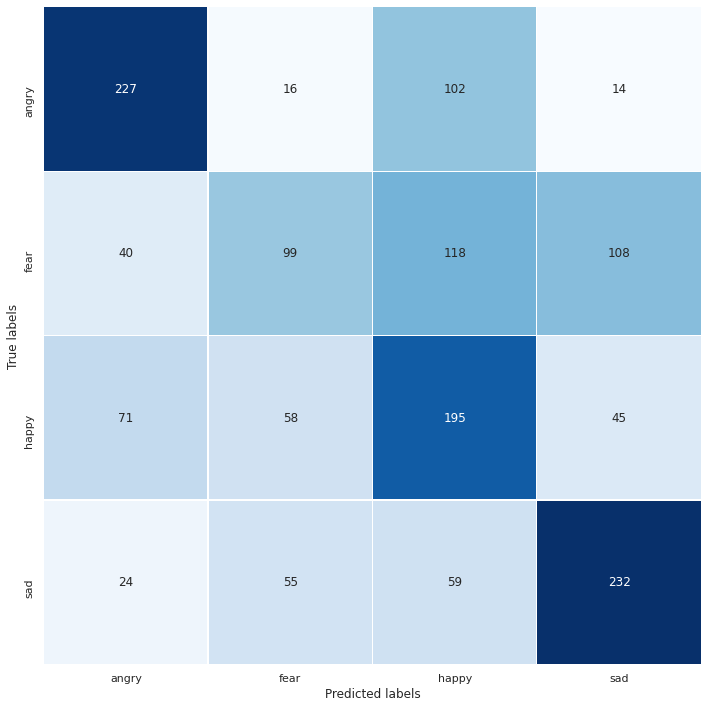

In [ ]:
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm,
                     index=observed_emotions,
                     columns=observed_emotions)
plt.figure(figsize=(10, 10))

sns.set(font_scale=1)


ax = sns.heatmap(df_cm, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.tight_layout()

name = 'tempo feature 51%51%51.png'
plt.savefig('/content/drive/MyDrive/Colab Notebooks/speech/dataset/Confusion matrix/mlp Confusion matrix for ' + name)

plt.show()

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       angry       0.63      0.63      0.63       359
        fear       0.43      0.27      0.33       365
       happy       0.41      0.53      0.46       369
         sad       0.58      0.63      0.60       370

    accuracy                           0.51      1463
   macro avg       0.51      0.51      0.51      1463
weighted avg       0.51      0.51      0.51      1463



In [ ]:
import pickle

filename = 'tempo MLP_0.51.sav'
pickle.dump(model, open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/Models/' + filename, 'wb'))
loaded_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/Models/' + filename, 'rb'))

### LGB

In [ ]:
preds = lgb_model.predict(x_test)

In [ ]:
predictions = []

for x in preds:
    predictions.append(np.argmax(x))

In [ ]:
results = pd.DataFrame()
results['Actual'] = y_test
results['Predicted'] = predictions

results['Actual'] = results['Actual'].map({0:'angry', 1:'fear', 2:'happy', 3:'sad'})
results['Predicted'] = results['Predicted'].map({0:'angry', 1:'fear', 2:'happy', 3:'sad'})
results.head()

,Actual,Predicted
0,sad,happy
1,happy,angry
2,happy,angry
3,sad,sad
4,sad,fear


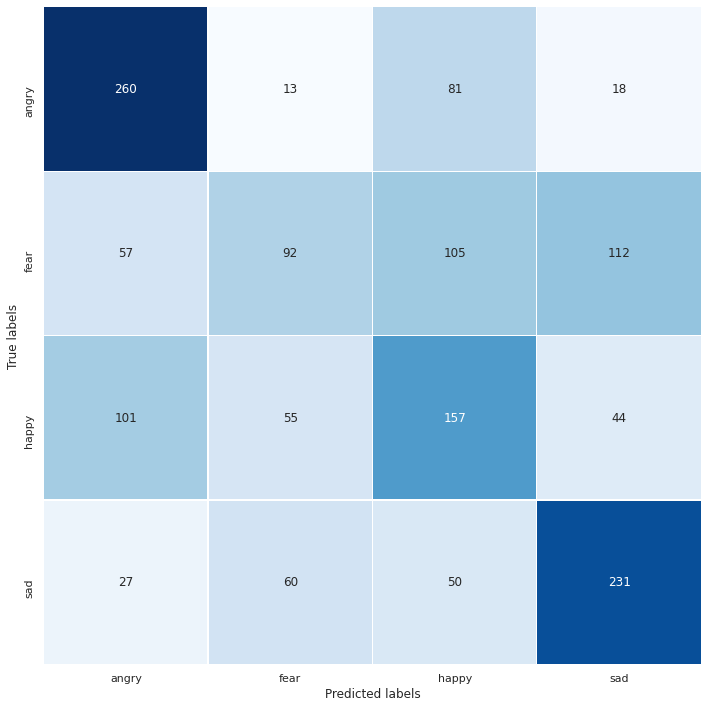

In [ ]:
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm,
                     index=observed_emotions,
                     columns=observed_emotions)

plt.figure(figsize=(10, 10))

sns.set(font_scale=1)

ax = sns.heatmap(df_cm, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# 
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.tight_layout()

name = 'tempo 51%49%49.png'
plt.savefig('/content/drive/MyDrive/Colab Notebooks/speech/dataset/Confusion matrix/lgbm Confusion matrix for ' + name)

plt.show()

In [ ]:
print(classification_report(y_test, predictions, target_names=observed_emotions))

              precision    recall  f1-score   support

       angry       0.58      0.70      0.64       372
        fear       0.42      0.25      0.31       366
       happy       0.40      0.44      0.42       357
         sad       0.57      0.63      0.60       368

    accuracy                           0.51      1463
   macro avg       0.49      0.50      0.49      1463
weighted avg       0.49      0.51      0.49      1463



In [ ]:
import pickle

filename = 'tempo lgbm_0.51.sav'
pickle.dump(lgb_model, open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/Models/' + filename, 'wb'))
loaded_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/Models/' + filename, 'rb'))